In [1]:
import tensorflow as tf
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import time
from IPython import display

In [2]:
tf.__version__

'2.0.0'

In [3]:
imgs_path = glob.glob(r'D:\163\gan20\pix2pix\datasets\cityscapes_data\train\*.jpg')

In [4]:
imgs_path[:3]

['D:\\163\\gan20\\pix2pix\\datasets\\cityscapes_data\\train\\1.jpg',
 'D:\\163\\gan20\\pix2pix\\datasets\\cityscapes_data\\train\\10.jpg',
 'D:\\163\\gan20\\pix2pix\\datasets\\cityscapes_data\\train\\100.jpg']

In [5]:
len(imgs_path)

2975

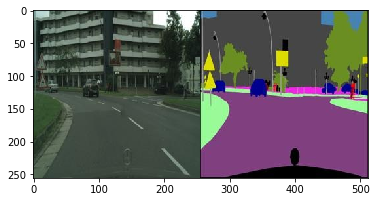

In [6]:
plt.imshow(tf.keras.preprocessing.image.load_img(imgs_path[0]))

In [7]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [8]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/127.5 - 1
    input_mask = tf.cast(input_mask, tf.float32)/127.5 - 1
    return input_image, input_mask

In [9]:
def load_image(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    input_mask = image[:, w:, :]
    input_image = tf.image.resize(input_image, (64, 64))
    input_mask = tf.image.resize(input_mask, (64, 64))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_mask, input_image

In [10]:
dataset = tf.data.Dataset.from_tensor_slices(imgs_path)

In [11]:
train = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
train

<ParallelMapDataset shapes: ((64, 64, 3), (64, 64, 3)), types: (tf.float32, tf.float32)>

In [13]:
BATCH_SIZE = 8
BUFFER_SIZE = 100

In [14]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

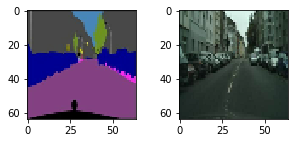

In [15]:
plt.figure(figsize=(5, 2))
for img, musk in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))

In [16]:
imgs_path_test = glob.glob(r'D:\163\gan20\pix2pix\datasets\cityscapes_data\val\*.jpg')

In [17]:
len(imgs_path_test)

500

In [18]:
dataset_test = tf.data.Dataset.from_tensor_slices(imgs_path_test)

In [19]:
def load_image_test(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    input_mask = image[:, w:, :]
    input_image = tf.image.resize(input_image, (64, 64))
    input_mask = tf.image.resize(input_mask, (64, 64))
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_mask, input_image

In [20]:
dataset_test = dataset_test.map(load_image_test)

In [21]:
dataset_test = dataset_test.batch(BATCH_SIZE)

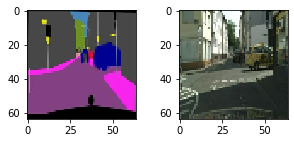

In [22]:
plt.figure(figsize=(5, 2))
for img, musk in dataset_test.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))

In [23]:
OUTPUT_CHANNELS = 3

In [24]:
def downsample(filters, size, apply_batchnorm=True):
#    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

    return result

In [25]:
def upsample(filters, size, apply_dropout=False):
#    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [26]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[64,64,3])

    down_stack = [
        downsample(32, 3, apply_batchnorm=False), # (bs, 32, 32, 32)
        downsample(64, 3), # (bs, 16, 16, 64)
        downsample(128, 3), # (bs, 8, 8, 128)
        downsample(256, 3), # (bs, 4, 4, 256)
        downsample(512, 3), # (bs, 2, 2, 512)
        downsample(512, 3), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 3, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(256, 3, apply_dropout=True), # (bs, 4, 4, 512)
        upsample(128, 3, apply_dropout=True), # (bs, 8, 8, 256)
        upsample(64, 3), # (bs, 16, 16, 128)
        upsample(32, 3), # (bs, 32, 32, 64)
    ]

#    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                         strides=2,
                                         padding='same',
                                         activation='tanh') # (bs, 64, 64, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [27]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [28]:
LAMBDA = 10

In [29]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [30]:
def Discriminator():
#    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[64, 64, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[64, 64, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 64, 64, channels*2)

    down1 = downsample(32, 3, False)(x) # (bs, 32, 32, 32)
    down2 = downsample(64, 3)(down1) # (bs, 16, 16, 64)
    down3 = downsample(128, 3)(down2) # (bs, 8, 8, 128)

    conv = tf.keras.layers.Conv2D(256, 3, strides=1,
                                  padding='same',
                                  use_bias=False)(down3) # (bs, 8, 8, 256)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    last = tf.keras.layers.Conv2D(1, 3, strides=1)(leaky_relu) # (bs, 8, 8, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [31]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [32]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [35]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(7, 2))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

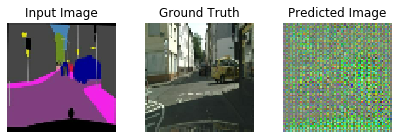

In [36]:
for example_input, example_target in dataset_test.take(1):
    generate_images(generator, example_input, example_target)

In [37]:
EPOCHS = 110

In [38]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [39]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs+1):
        if epoch%10 == 0:
            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        for n, (input_image, target) in train_ds.enumerate():
            if n%10 == 0:
                print('.', end='')
            train_step(input_image, target, epoch)
        print()

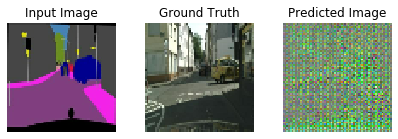

Epoch:  0
......................................
Epoch:  1
......................................
Epoch:  2
......................................
Epoch:  3
......................................
Epoch:  4
......................................
Epoch:  5
......................................
Epoch:  6
......................................
Epoch:  7
......................................
Epoch:  8
......................................
Epoch:  9
......................................


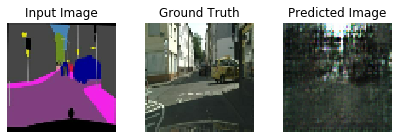

Epoch:  10
......................................
Epoch:  11
......................................
Epoch:  12
......................................
Epoch:  13
......................................
Epoch:  14
......................................
Epoch:  15
......................................
Epoch:  16
......................................
Epoch:  17
......................................
Epoch:  18
......................................
Epoch:  19
......................................


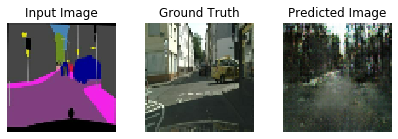

Epoch:  20
......................................
Epoch:  21
......................................
Epoch:  22
......................................
Epoch:  23
......................................
Epoch:  24
......................................
Epoch:  25
......................................
Epoch:  26
......................................
Epoch:  27
......................................
Epoch:  28
......................................
Epoch:  29
......................................


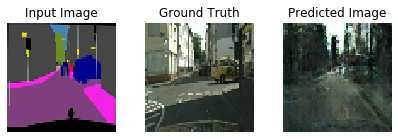

Epoch:  30
......................................
Epoch:  31
......................................
Epoch:  32
......................................
Epoch:  33
......................................
Epoch:  34
......................................
Epoch:  35
......................................
Epoch:  36
......................................
Epoch:  37
......................................
Epoch:  38
......................................
Epoch:  39
......................................


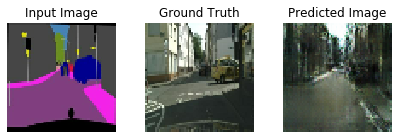

Epoch:  40
......................................
Epoch:  41
......................................
Epoch:  42
......................................
Epoch:  43
......................................
Epoch:  44
......................................
Epoch:  45
......................................
Epoch:  46
......................................
Epoch:  47
......................................
Epoch:  48
......................................
Epoch:  49
......................................


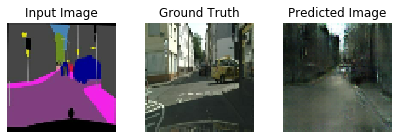

Epoch:  50
......................................
Epoch:  51
......................................
Epoch:  52
......................................
Epoch:  53
......................................
Epoch:  54
......................................
Epoch:  55
......................................
Epoch:  56
......................................
Epoch:  57
......................................
Epoch:  58
......................................
Epoch:  59
......................................


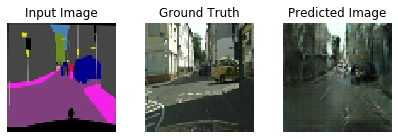

Epoch:  60
......................................
Epoch:  61
......................................
Epoch:  62
......................................
Epoch:  63
......................................
Epoch:  64
......................................
Epoch:  65
......................................
Epoch:  66
......................................
Epoch:  67
......................................
Epoch:  68
......................................
Epoch:  69
......................................


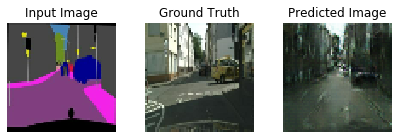

Epoch:  70
......................................
Epoch:  71
......................................
Epoch:  72
......................................
Epoch:  73
......................................
Epoch:  74
......................................
Epoch:  75
......................................
Epoch:  76
......................................
Epoch:  77
......................................
Epoch:  78
......................................
Epoch:  79
......................................


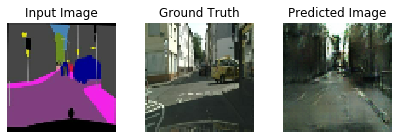

Epoch:  80
......................................
Epoch:  81
......................................
Epoch:  82
......................................
Epoch:  83
......................................
Epoch:  84
......................................
Epoch:  85
......................................
Epoch:  86
......................................
Epoch:  87
......................................
Epoch:  88
......................................
Epoch:  89
......................................


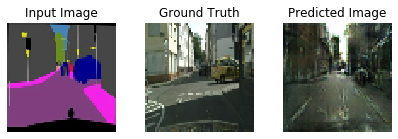

Epoch:  90
......................................
Epoch:  91
......................................
Epoch:  92
......................................
Epoch:  93
......................................
Epoch:  94
......................................
Epoch:  95
......................................
Epoch:  96
......................................
Epoch:  97
......................................
Epoch:  98
......................................
Epoch:  99
......................................


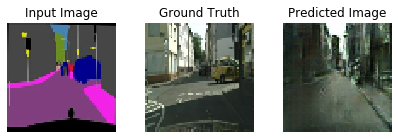

Epoch:  100
......................................
Epoch:  101
......................................
Epoch:  102
......................................
Epoch:  103
......................................
Epoch:  104
......................................
Epoch:  105
......................................
Epoch:  106
......................................
Epoch:  107
......................................
Epoch:  108
......................................
Epoch:  109
......................................


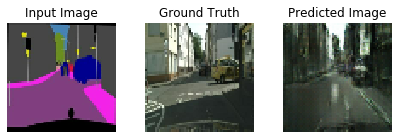

Epoch:  110
......................................


In [40]:
fit(train_dataset, EPOCHS, dataset_test)

In [41]:
AD_EPOCHS = 50

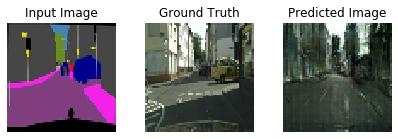

Epoch:  0
......................................
Epoch:  1
......................................
Epoch:  2
......................................
Epoch:  3
......................................
Epoch:  4
......................................
Epoch:  5
......................................
Epoch:  6
......................................
Epoch:  7
......................................
Epoch:  8
......................................
Epoch:  9
......................................


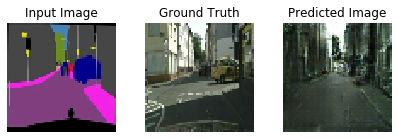

Epoch:  10
......................................
Epoch:  11
......................................
Epoch:  12
......................................
Epoch:  13
......................................
Epoch:  14
......................................
Epoch:  15
......................................
Epoch:  16
......................................
Epoch:  17
......................................
Epoch:  18
......................................
Epoch:  19
......................................


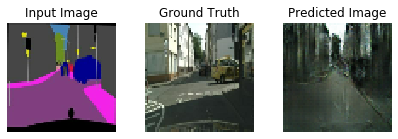

Epoch:  20
......................................
Epoch:  21
......................................
Epoch:  22
......................................
Epoch:  23
......................................
Epoch:  24
......................................
Epoch:  25
......................................
Epoch:  26
......................................
Epoch:  27
......................................
Epoch:  28
......................................
Epoch:  29
......................................


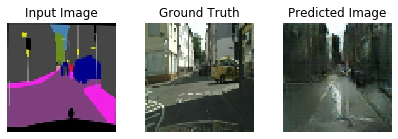

Epoch:  30
......................................
Epoch:  31
......................................
Epoch:  32
......................................
Epoch:  33
......................................
Epoch:  34
......................................
Epoch:  35
......................................
Epoch:  36
......................................
Epoch:  37
......................................
Epoch:  38
......................................
Epoch:  39
......................................


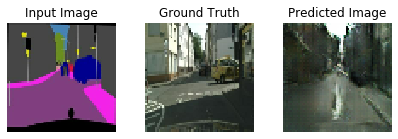

Epoch:  40
......................................
Epoch:  41
......................................
Epoch:  42
......................................
Epoch:  43
......................................
Epoch:  44
......................................
Epoch:  45
......................................
Epoch:  46
......................................
Epoch:  47
......................................
Epoch:  48
......................................
Epoch:  49
......................................


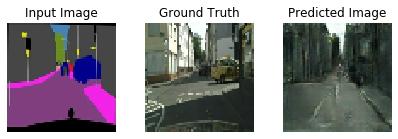

Epoch:  50
......................................


In [42]:
fit(train_dataset, AD_EPOCHS, dataset_test)

In [44]:
generator.save('pix2pix.h5')

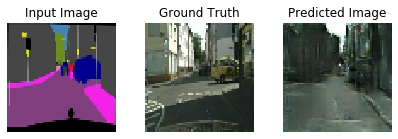

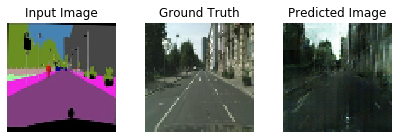

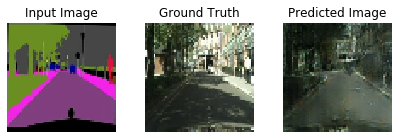

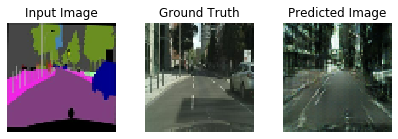

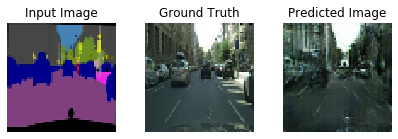

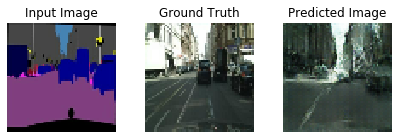

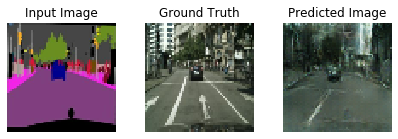

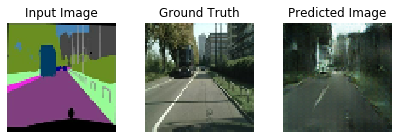

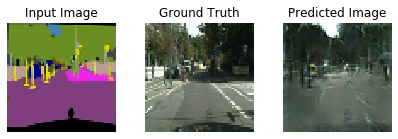

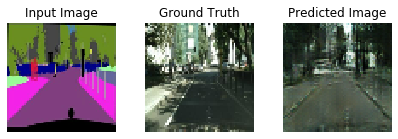

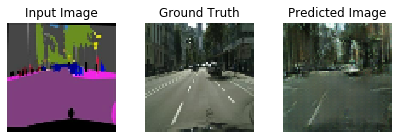

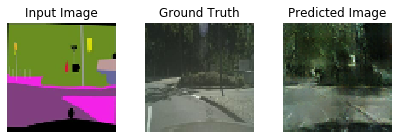

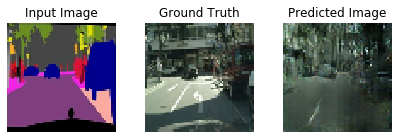

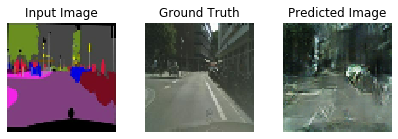

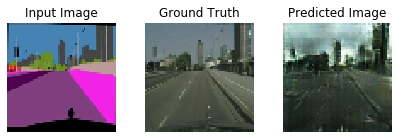

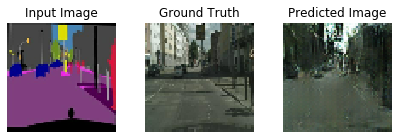

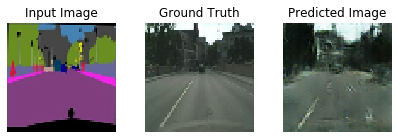

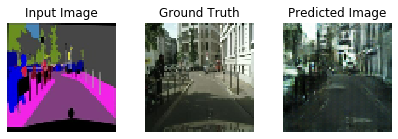

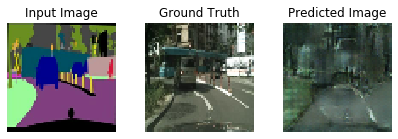

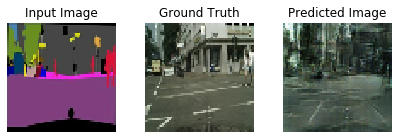

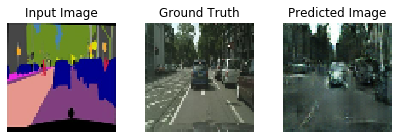

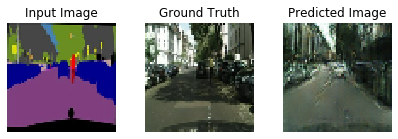

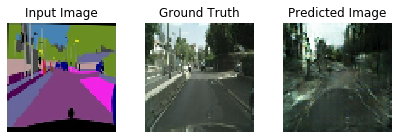

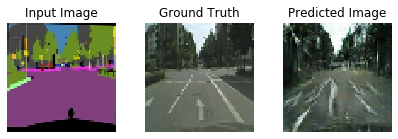

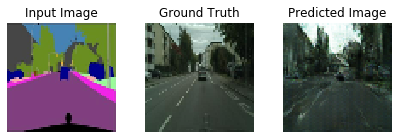

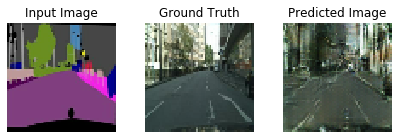

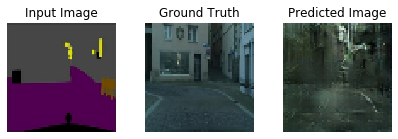

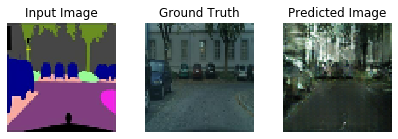

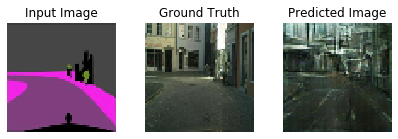

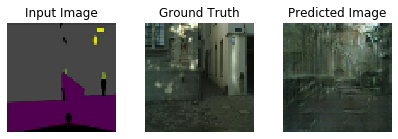

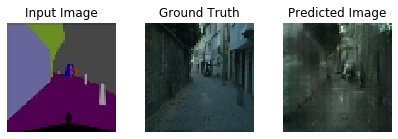

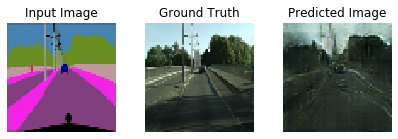

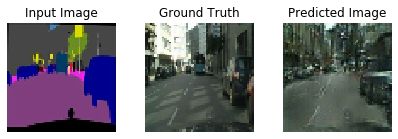

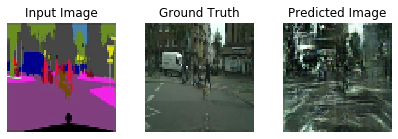

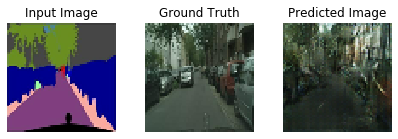

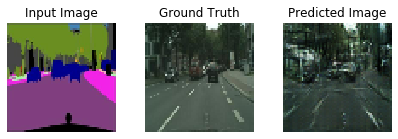

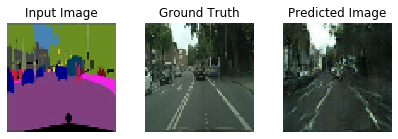

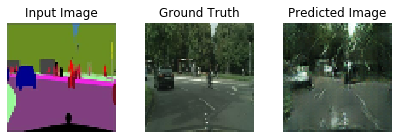

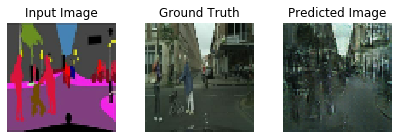

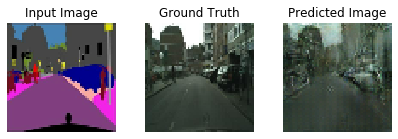

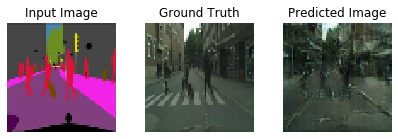

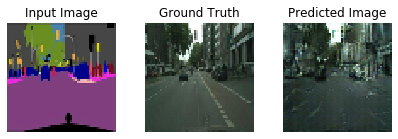

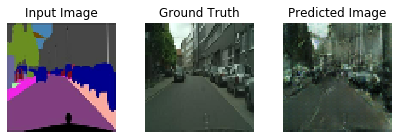

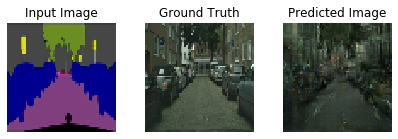

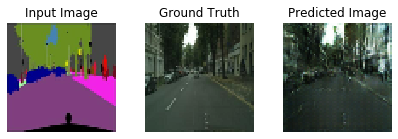

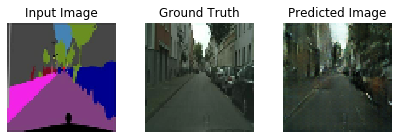

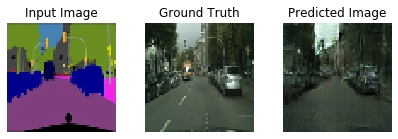

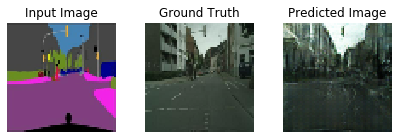

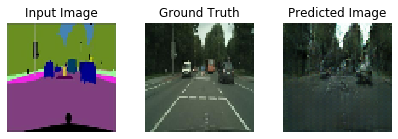

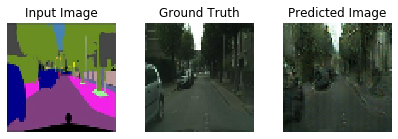

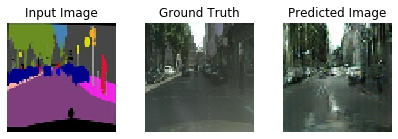

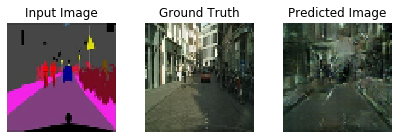

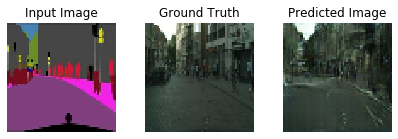

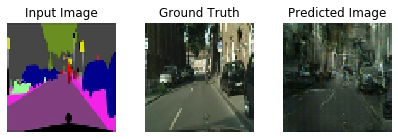

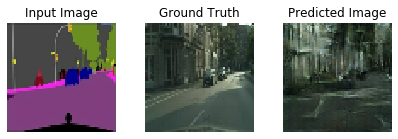

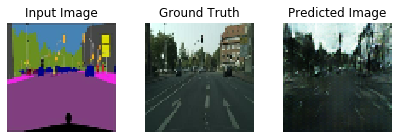

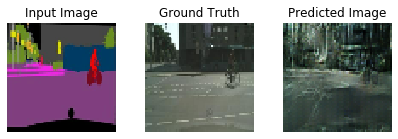

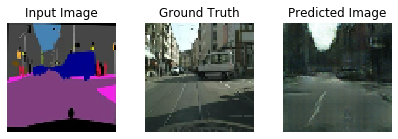

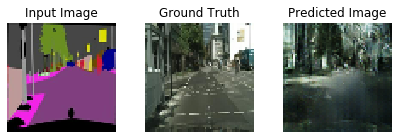

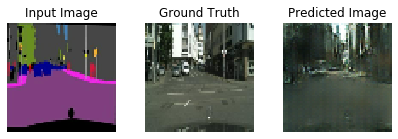

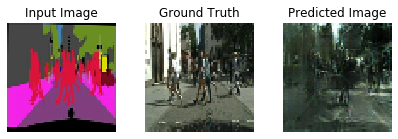

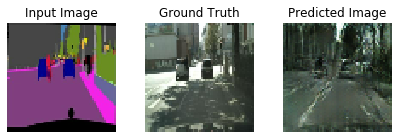

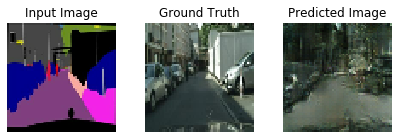

In [46]:
for input_image, ground_true in dataset_test:
    generate_images(generator, input_image, ground_true)